In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt 
import seaborn
import statsmodels.api as sm
from scipy.stats import zscore
from statsmodels import regression
from statsmodels.tsa.stattools import coint

In [2]:
data = pd.read_excel('cotacaotreino_win_dol.xlsx')

In [3]:
data.head()

,time,open WIN$,high WIN$,low WIN$,close WIN$,volumeWIN$,open DOL$,high DOL$,low DOL$,close DOL$,volumeDOL$
0,2016-12-21 13:25:00,70695,70852,70689,70815,8192,3829.959,3831.106,3829.959,3831.106,645
1,2016-12-21 13:30:00,70815,70815,70477,70544,22378,3831.106,3832.252,3830.532,3831.106,1160
2,2016-12-21 13:35:00,70538,70664,70501,70622,8733,3831.106,3831.106,3829.959,3830.532,860
3,2016-12-21 13:40:00,70628,70664,70520,70556,6383,3831.106,3831.106,3828.239,3828.812,885
4,2016-12-21 13:45:00,70556,70652,70532,70592,5014,3829.386,3831.106,3829.386,3831.106,1295


In [4]:
3.831*10000

38310.0

In [5]:
70695*.2

14139.0

In [6]:
data = data[['close DOL$','close WIN$']]

In [7]:
data

,close DOL$,close WIN$
0,3831.106,70815
1,3831.106,70544
2,3830.532,70622
3,3828.812,70556
4,3831.106,70592
...,...,...
89243,5492.138,80275
89244,5492.639,80315
89245,5494.142,80180
89246,5498.650,80140


### Vamos transformar a cotação de pontos, para valor financeiro de 1 minicontrato de indice, e 1 minicontrato de dolar 

In [8]:
data['close WIN$'], data['close DOL$'] = data['close WIN$']*.2, data['close DOL$']*10

In [9]:
data

,close DOL$,close WIN$
0,38311.06,14163.0
1,38311.06,14108.8
2,38305.32,14124.4
3,38288.12,14111.2
4,38311.06,14118.4
...,...,...
89243,54921.38,16055.0
89244,54926.39,16063.0
89245,54941.42,16036.0
89246,54986.50,16028.0


In [10]:
class Fica_rico():
    def __init__(self, dados, tickers):
        self.dados = dados[:3500]
        #seleciona os tickers
        self.t1 = tickers[0]
        self.t2 = tickers[1]
        #calcula variações
        self.s1 = self.dados[self.t1].pct_change()[1:]
        self.s2 = self.dados[self.t2].pct_change()[1:]
        self.dados = self.dados[1:]
        
        self.posicionado = 0 #está neutro
        self.result_1 = 0
        self.result_2 = 0
        self.fin = 2000 #valor financeiro disponivel
        self.volume = 0
        
        self.dic_resultados = {}
        self.dic_resultados['S1'] = []
        self.dic_resultados['S2'] = []
        self.carteira_vs_time = [] #desempenho da carteira ao longo do tempo 

    
    #funcao para calcular o zscores do spread entre os pares
    def calcula_zscore_spread(self,s1,s2):
        s1 = sm.add_constant(s1)
        results = sm.OLS(s2,s1).fit()
        s1 = s1[self.t1]
        b = results.params[self.t1]
        spread = s2 - (b*s1)
        zs = zscore(spread)[-1]
        return zs
    
    def calcula_volume(self,):
        return (self.fin*.06/2)//25
        
    #condicoes para entrar/encerrar uma operacao 
    def condicoes(self,zs,preco_s1,preco_s2, razao):
        if zs >= 1.1 and self.posicionado == 0:
            self.volume = self.calcula_volume()
            print(f'volume: {self.volume}')
            self.posicionado = 1 #está posicionado
            self.q = razao #para deixa igual o valor de s1 e s2
            self.result_1 += preco_s1*self.volume #short (credito financeiro)
            self.result_2 -= preco_s2*self.q*self.volume #long (debito financeiro)
            
        elif (zs < .08) and self.posicionado == 1:
            
            self.posicionado = 0 #está neutro
            
            self.result_1 -= preco_s1*self.volume #encerra posicao short
            self.result_2 += preco_s2*self.q*self.volume #encerra posicao long
            resultado_trade = self.result_1 + self.result_2
            self.fin += resultado_trade
            
            self.carteira_vs_time.append(self.fin)
            
            self.dic_resultados['S1'].append(self.result_1)
            self.dic_resultados['S2'].append(self.result_2)

            self.result_1, self.result_2, self.volume = 0,0,0 #reseta operacao
            
    def opera(self,):
        c = 0
        for index in range(70,len(self.dados)):
            s1 = self.s1[c:index]
            s2 = self.s2[c:index]
            preco_s1 = self.dados[self.t1][self.dados.index == index].values[0]
            preco_s2 = self.dados[self.t2][self.dados.index == index].values[0]
            q12 = preco_s1/preco_s2
        
            zs = self.calcula_zscore_spread(s1,s2)
            self.condicoes(zs,preco_s1,preco_s2,razao=q12)

In [11]:
tickers = ['close DOL$','close WIN$']

In [12]:
modelo = Fica_rico(data,tickers)

In [13]:
modelo.calcula_volume()

2.0

In [14]:
modelo.opera()

volume: 2.0
volume: 2.0
volume: 2.0
volume: 2.0
volume: 2.0
volume: 2.0
volume: 2.0
volume: 2.0
volume: 2.0
volume: 3.0
volume: 3.0
volume: 3.0
volume: 3.0
volume: 3.0
volume: 3.0
volume: 3.0
volume: 3.0
volume: 3.0
volume: 3.0
volume: 3.0
volume: 3.0
volume: 3.0
volume: 3.0
volume: 3.0
volume: 3.0
volume: 3.0
volume: 3.0
volume: 3.0
volume: 3.0
volume: 3.0
volume: 3.0
volume: 3.0
volume: 3.0
volume: 2.0
volume: 2.0
volume: 3.0
volume: 2.0
volume: 3.0
volume: 3.0
volume: 2.0
volume: 2.0
volume: 2.0
volume: 2.0
volume: 2.0
volume: 1.0
volume: 1.0
volume: 1.0
volume: 1.0
volume: 1.0
volume: 1.0
volume: 1.0
volume: 1.0
volume: 1.0
volume: 1.0
volume: 1.0
volume: 1.0
volume: 1.0
volume: 1.0
volume: 1.0
volume: 1.0
volume: 1.0
volume: 1.0
volume: 1.0
volume: 1.0
volume: 1.0
volume: 1.0
volume: 1.0
volume: 1.0
volume: 1.0
volume: 2.0
volume: 2.0
volume: 2.0
volume: 2.0
volume: 1.0
volume: 1.0
volume: 1.0
volume: 1.0
volume: 1.0
volume: 1.0
volume: 2.0
volume: 2.0
volume: 2.0
volume: 2.0
volu

In [15]:
modelo.fin

2384.903241187072

In [16]:
res1 = modelo.dic_resultados['S1']
res2 = modelo.dic_resultados['S2']
for i in range(len(res1)):
    print(f's1: {res1[i]:.2f} s2: {res2[i]:.2f}')
    print(f'Resultado: {(res1[i]+res2[i]):.2f} \n')


s1: -34.40 s2: -111.13
Resultado: -145.53 

s1: 11.46 s2: -66.22
Resultado: -54.76 

s1: 57.32 s2: 6.52
Resultado: 63.84 

s1: -22.94 s2: 19.60
Resultado: -3.34 

s1: -11.46 s2: -26.06
Resultado: -37.52 

s1: -11.46 s2: 91.67
Resultado: 80.21 

s1: 114.68 s2: -78.48
Resultado: 36.20 

s1: 263.74 s2: 194.06
Resultado: 457.80 

s1: 149.06 s2: 6.38
Resultado: 155.44 

s1: -17.19 s2: 250.24
Resultado: 233.05 

s1: 0.00 s2: -19.02
Resultado: -19.02 

s1: -86.01 s2: -87.06
Resultado: -173.07 

s1: 68.82 s2: -57.10
Resultado: 11.72 

s1: -51.60 s2: 172.46
Resultado: 120.86 

s1: -171.99 s2: 94.75
Resultado: -77.24 

s1: 0.00 s2: 0.00
Resultado: 0.00 

s1: 34.38 s2: 9.47
Resultado: 43.85 

s1: -17.22 s2: -9.44
Resultado: -26.66 

s1: -17.19 s2: -9.43
Resultado: -26.62 

s1: -17.19 s2: -28.19
Resultado: -45.38 

s1: 137.61 s2: -47.02
Resultado: 90.59 

s1: 206.43 s2: 65.63
Resultado: 272.06 

s1: 17.19 s2: -9.35
Resultado: 7.84 

s1: 34.41 s2: -28.09
Resultado: 6.32 

s1: -103.23 s2: -57.88
Res

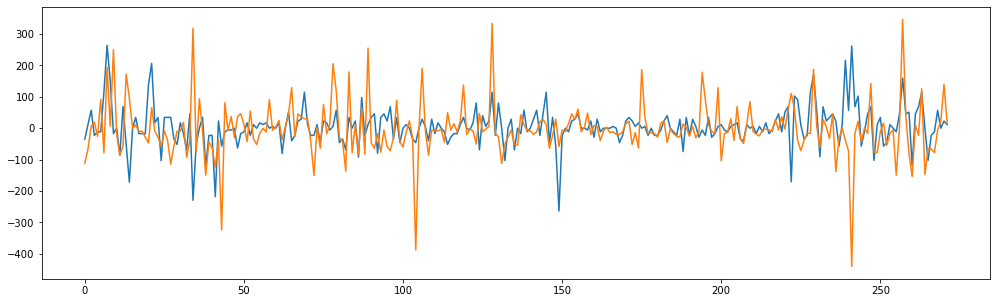

In [17]:
plt.figure(figsize=[17,5])

plt.plot(res1)
plt.plot(res2)

plt.show()

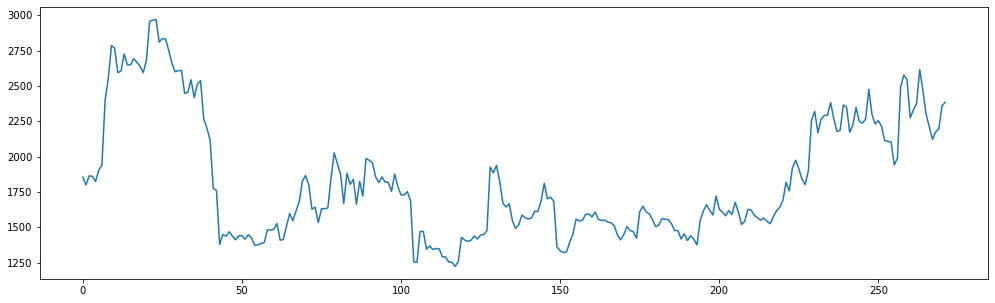

In [18]:
plt.figure(figsize=[17,5])

plt.plot(modelo.carteira_vs_time)
plt.show()